# Presentation

L'objectif de ce notebook est de réaliser une analyse générale de la course Sainté Lyon 2024 dans une premier temps, puis de répondre dans un second temps à la question : `Sainté Lyon 2024 : partir prudemment permet-il de mieux performer ?`

- Input : race_result.csv
- Output : analyse servant de support à l'article de presse

In [55]:
VERBOSE = True

# 0. Imports

In [56]:
import sys
from pathlib import Path

# Definition du chemin vers notre code source local
sys.path.append(str(Path().resolve().parent))

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import seaborn as sns
from scipy.stats import ttest_ind
import gpxpy

from src.definitions import CLEAN_DATA_PATH, RAVITAILLEMENTS
from src.utils import seconds_to_time

In [58]:
INTER_POINTS = [
    f"{i+1}_{ravitaillement['nom']}" for i, ravitaillement in enumerate(RAVITAILLEMENTS)
]

# 1. Télécharger la donnée

In [59]:
race_results_df = pd.read_csv(CLEAN_DATA_PATH / "race_results.csv")

Dans ce notebook nous utiliserons également la trace gpx de la course, surtout à des fins de visualisation et d'interprétation (source: https://saintelyon.v3.livetrail.net/fr/2024/races/82km?view=withdrawals).

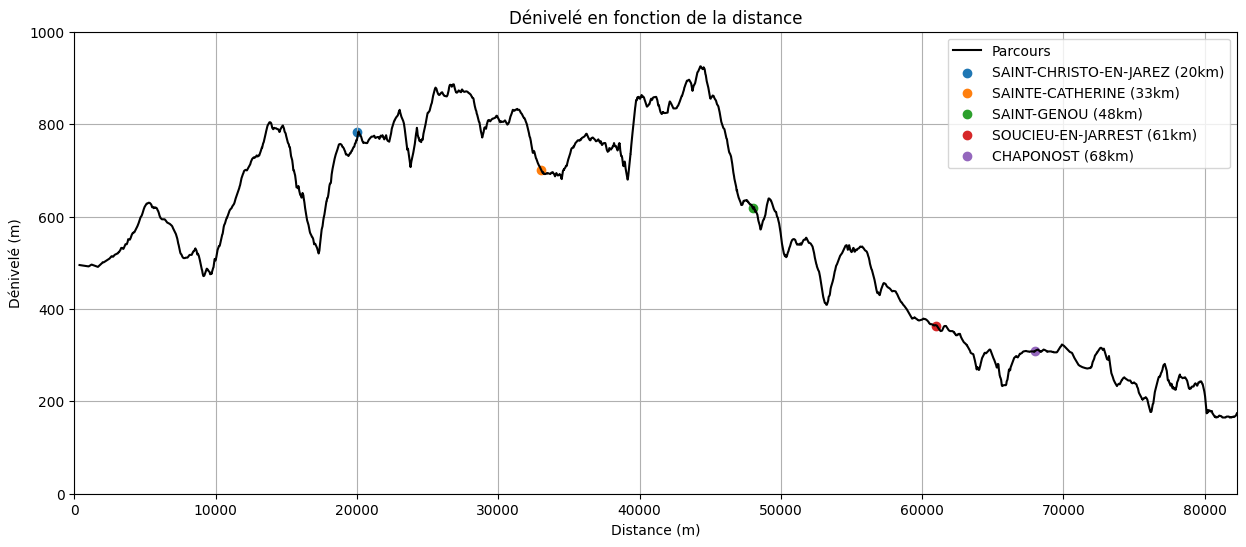

In [60]:
# Charger la trace GPX
with open(CLEAN_DATA_PATH / "track.gpx", "r") as file:
    gpx = gpxpy.parse(file)

# Plot du parcours
if VERBOSE:
    distances = []  # distance cumulée en mètres
    altitudes = []  # altitudes des points
    prev_point = None
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                if prev_point is not None:
                    dist = geodesic(
                        (prev_point.latitude, prev_point.longitude), 
                        (point.latitude, point.longitude)
                    ).meters
                    if distances == []:
                        distances.append(dist)
                    else:
                        distances.append(distances[-1] + dist)    
                    altitudes.append(point.elevation)
                prev_point = point

    plt.figure(figsize=(15, 6))

    # parcours
    plt.plot(distances, altitudes, color="black", label='Parcours')
    plt.xlim([0, distances[-1]])
    plt.xlabel('Distance (m)')
    plt.ylim([0, 1000])
    plt.ylabel('Dénivelé (m)')

    # ravitaillements
    for ravitaillement in RAVITAILLEMENTS:
        dist = ravitaillement["distance"]
        alt = altitudes[next((i for i, d in enumerate(distances) if d > dist), None)]
        plt.scatter(x=[dist], y=alt, label=ravitaillement["nom"] + f" ({round(dist/1000)}km)")

    plt.title('Dénivelé en fonction de la distance')
    plt.grid(True)
    plt.legend()
    plt.show()

# 2. Distributions de temps de course

Temps moyen des coureurs = 12h 4min 1s (6.71km/h)
Quantile 0.05 = 8h 54min 53s (9.09km/h)
Quantile 0.25 = 10h 45min 28s (7.53km/h)
Quantile 0.75 = 13h 19min 11s (6.08km/h)
Quantile 0.95 = 15h 27min 19s (5.24km/h)


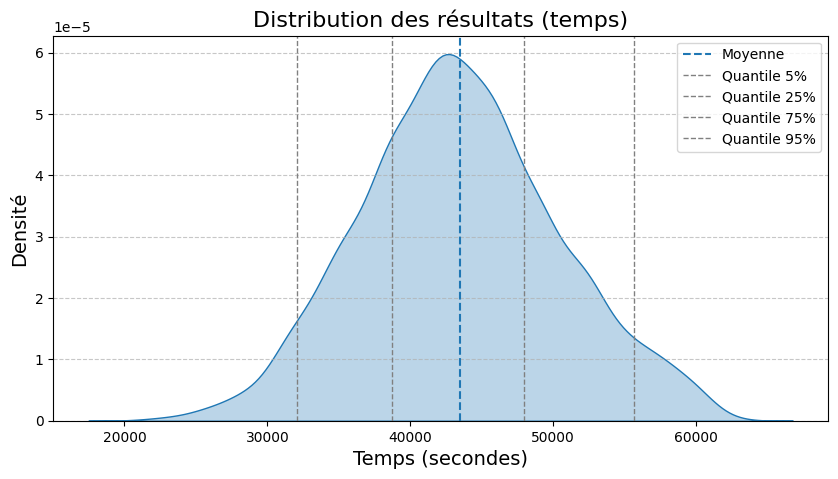

In [61]:
if VERBOSE:
    plt.figure(figsize=(10, 5))

    sns.kdeplot(data=race_results_df, x="temps", fill=True, common_norm=False, alpha=0.3, legend=True)

    mean = race_results_df["temps"].mean()
    temps = seconds_to_time(int(mean))
    print(f"Temps moyen des coureurs = {temps[0]}h {temps[1]}min {temps[2]}s ({round((81000/mean)*3.6, 2)}km/h)")
    plt.axvline(mean, linestyle="--", linewidth=1.5, label=f"Moyenne")

    # Calcul des quantiles
    quantiles = race_results_df["temps"].quantile([0.05, 0.25, 0.75, 0.95])
    for q, value in quantiles.items():
        temps = seconds_to_time(int(value))
        print(f"Quantile {q} = {temps[0]}h {temps[1]}min {temps[2]}s ({round((81000/value)*3.6, 2)}km/h)")
        plt.axvline(value, color="gray", linestyle="--", linewidth=1, label=f"Quantile {int(q*100)}%")

    plt.title("Distribution des résultats (temps)", fontsize=16)
    plt.xlabel("Temps (secondes)", fontsize=14)
    plt.ylabel("Densité", fontsize=14)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

- La distribution des résultats suit une distribution normale, comme c'est souvent le cas en course à pied. Le temps d'arrivé moyen était de 12h 1min 46s, ce qui correspond à du 6.73 km/h.

- 5% des coureurs, sont arrivés en moins de 8h52 et 95% des coureurs sont arrivés en moins de 15h27.

- Environ la moitié des coureurs sont arrivés entre 10h45 et 13h45.

sexe
H    5247
F     692
Name: count, dtype: int64

Temps moyen pour les coureurs F = 12h 52min 37s
Temps moyen pour les coureurs H = 11h 57min 36s


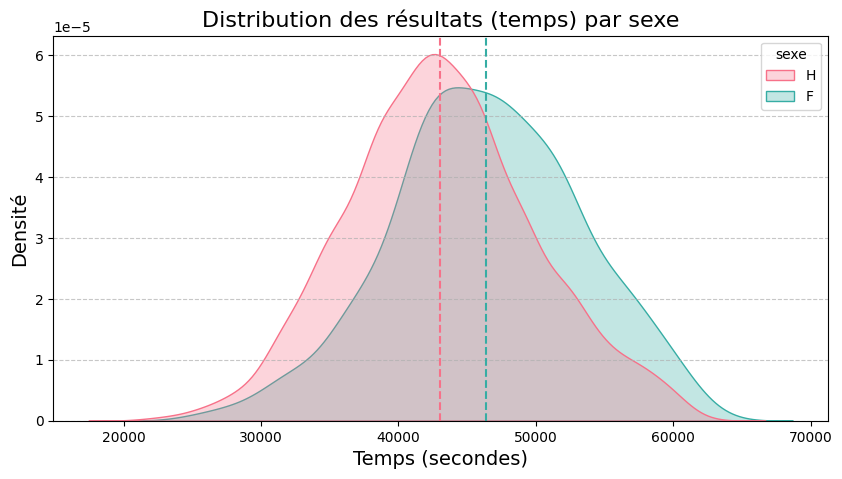

In [62]:
if VERBOSE:
    print(race_results_df["sexe"].value_counts())
    print()

    palette_dict = dict(zip(
        race_results_df["sexe"].unique(), 
        sns.color_palette("husl", len(race_results_df["sexe"].unique()))
    ))

    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=race_results_df, x="temps", hue="sexe", fill=True, common_norm=False, alpha=0.3, legend=True, palette=palette_dict)

    category_means = race_results_df.groupby("sexe")["temps"].mean()
    for category, mean in category_means.items():
        temps = seconds_to_time(int(mean))
        print(f"Temps moyen pour les coureurs {category} = {temps[0]}h {temps[1]}min {temps[2]}s")
        plt.axvline(mean, color=palette_dict[category], linestyle="--", linewidth=1.5, label=f"Moyenne {category}")


    plt.title("Distribution des résultats (temps) par sexe", fontsize=16)
    plt.xlabel("Temps (secondes)", fontsize=14)
    plt.ylabel("Densité", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [63]:
if VERBOSE:
    print(
        ttest_ind(
            race_results_df[race_results_df["sexe"] == "H"]["temps"].to_numpy(),
            race_results_df[race_results_df["sexe"] == "F"]["temps"].to_numpy(),
        )
    )

Ttest_indResult(statistic=-11.885009573830867, pvalue=3.276482878117085e-32)


- Sans grande surprise, les hommes sont arrivés en moyenne 1h avant les femmes.

- Les distributions sont bien statistiquement différentes.

- Les distributions des deux catégories n'ont pas tout a fait les mêmes caractéristiques. En effet, la distribution des hommes est plus dense que celle des femmes au niveau des petits chronos, alors que celle des femmes est plus dense vers la fin du classement. Ceci pourrait s'expliquer par le fait qu'il y a une plus grande densité d'athlètes "compétitifs" chez les hommes que chez les femmes.

categorie
SE-M0H    2974
M1-M2H    1344
M3-M4H     702
SE-M0F     392
M1-M2F     198
M5-M6H     123
ES H        93
M3-M4F      86
M5-M6F      12
M7-M8H      11
ES F         4
Name: count, dtype: int64

Temps moyen pour les coureurs ES F = 13h 12min 56s
Temps moyen pour les coureurs ES H = 11h 30min 2s
Temps moyen pour les coureurs M1-M2F = 13h 5min 54s
Temps moyen pour les coureurs M1-M2H = 12h 9min 7s
Temps moyen pour les coureurs M3-M4F = 13h 50min 55s
Temps moyen pour les coureurs M3-M4H = 12h 45min 55s
Temps moyen pour les coureurs M5-M6F = 14h 8min 6s
Temps moyen pour les coureurs M5-M6H = 13h 19min 14s
Temps moyen pour les coureurs M7-M8H = 14h 20min 17s
Temps moyen pour les coureurs SE-M0F = 12h 30min 35s
Temps moyen pour les coureurs SE-M0H = 11h 37min 57s


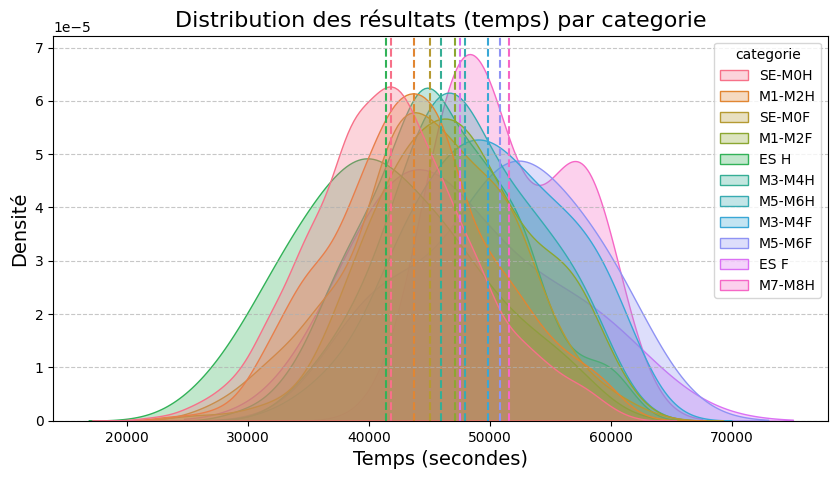

In [64]:
if VERBOSE:
    print(race_results_df["categorie"].value_counts())
    print()

    palette_dict = dict(zip(
        race_results_df["categorie"].unique(), 
        sns.color_palette("husl", len(race_results_df["categorie"].unique()))
    ))

    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=race_results_df, x="temps", hue="categorie", fill=True, common_norm=False, alpha=0.3, legend=True, palette=palette_dict)

    category_means = race_results_df.groupby("categorie")["temps"].mean()
    for category, mean in category_means.items():
        temps = seconds_to_time(int(mean))
        print(f"Temps moyen pour les coureurs {category} = {temps[0]}h {temps[1]}min {temps[2]}s")
        plt.axvline(mean, color=palette_dict[category], linestyle="--", linewidth=1.5, label=f"Moyenne {category}")


    plt.title("Distribution des résultats (temps) par categorie", fontsize=16)
    plt.xlabel("Temps (secondes)", fontsize=14)
    plt.ylabel("Densité", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

- Les écarts entre catégories suivent globalement l'évolution de l'age : plus les athlètes sont jeunes, plus ils performent.
- Il est intéressant de remarquer que la catégorie avec la meilleure moyenne n'est pas celle des SE-M0, alors que l'on dit souvent que c'est l'age auquel on est le plus compétitif en ultra trail, mais plutôt les Espoirs (-23 ans). Ceci montre que les concurrents sont compétitifs de plus en plus tôt. Je suis d'ailleurs prêt à parier que ce n'était pas le cas il y a quelques années.

- Une catégorie sors du lot et semble avoir une distribution différente des autres (non normale) : les M7-M8H. En effet il semblerait qu'il y aurait deux "bosses", une première vers la moyenne et une seconde plus tard, comme s'il y avait deux types de profils de coureurs bien distincts au sein de la catégorie. Néanmoins, il n'y a que 11 points de donnée, ce qui est trop peu pour mener à une conclusion.

# 3. Valait-il mieux partir vite lors de la Sainté Lyon 2024 ?

A partir d'ici, l'idée sera d'analyser la performance des athlètes tout au long de la course grâce à leurs temps de passage aux différents points que nous avons. 

Nous essayerons également d'analyser leur performance au regard du parcours. 

Enfin, nous répondrons à la question: Valait-il mieux partir vite lors de la Sainté Lyon 2024 ?

## 3.1. Définition de la VAP moyenne par segment

Ici nous allons calculer une VAP (Vitesse Ajustée à la Pente) moyenne par segment pour chaque athlète en utilisant le dénivellé cumulé sur la portion. Etant donné le peu d'information utilisable, nous allons utiliser une formule simple: chaque 130m de dénivelé positif cumulé vaut 1km à plat.

In [87]:
# calcul du d+ cumulé par segment
alt_cumul_segment = {}
idx_debut = 0
for ravitaillement in RAVITAILLEMENTS:
    dist_fin = ravitaillement["distance"]
    idx_fin = next((i for i, d in enumerate(distances) if d > dist_fin), None)

    # d+ cumulé
    alt_cumul = 0
    for idx in range(idx_debut+1, idx_fin):
        if altitudes[idx] > altitudes[idx-1]:
            alt_cumul += altitudes[idx] - altitudes[idx-1]

    alt_cumul_segment[ravitaillement["nom"]] = alt_cumul
    idx_debut = idx_fin

# ajout du dernier segment entre CHAPONOST et LYON
alt_cumul = 0
for idx in range(idx_debut+1, len(distances)):
    if altitudes[idx] > altitudes[idx-1]:
        alt_cumul += altitudes[idx] - altitudes[idx-1]
alt_cumul_segment["LYON"] = alt_cumul

In [88]:
# calcul de la VAP sur chaque segment (secondes au km)
temps_debut_segment = np.zeros(len(race_results_df))
dist_debut = 0
for idx, ravitaillement in enumerate(RAVITAILLEMENTS):
    nom = ravitaillement["nom"]
    dist_ajust = (ravitaillement["distance"] - dist_debut) / 1000 + alt_cumul_segment[nom] / 130
    race_results_df[f"VAP_segment_{idx}"] = round((race_results_df[f"temps_inter_{idx+1}_{nom}"] - temps_debut_segment) / dist_ajust)

    temps_debut_segment = race_results_df[f"temps_inter_{idx+1}_{nom}"]
    dist_debut = ravitaillement["distance"]

# calcul de la VAP sur le dernier segment
dist_ajust = (distances[-1] - RAVITAILLEMENTS[-1]["distance"]) / 1000 + alt_cumul_segment["LYON"] / 130
race_results_df[f"VAP_segment_5"] = round((race_results_df[f"temps"] - temps_debut_segment) / dist_ajust)

In [89]:
if VERBOSE:
    display(race_results_df[[f"VAP_segment_{i}" for i in range(len(RAVITAILLEMENTS)+1)]])

,VAP_segment_0,VAP_segment_1,VAP_segment_2,VAP_segment_3,VAP_segment_4,VAP_segment_5
0,186.0,211.0,212.0,216.0,224.0,206.0
1,186.0,211.0,215.0,220.0,238.0,232.0
2,186.0,212.0,221.0,244.0,258.0,226.0
3,196.0,218.0,224.0,230.0,258.0,237.0
4,186.0,212.0,230.0,241.0,259.0,246.0
...,...,...,...,...,...,...
5934,455.0,605.0,585.0,609.0,700.0,803.0
5935,504.0,631.0,549.0,597.0,656.0,776.0
5936,492.0,650.0,549.0,597.0,655.0,776.0
5937,477.0,699.0,596.0,614.0,687.0,726.0


## 3.2. Evolution de VAP au cours de la course

In [90]:
colors = {
    "H": "blue",
    "F": "red",
    "Top 100": "green"
}

palette_dict = dict(zip(
        list(colors.keys()), 
        sns.color_palette(list(colors.values()))
    ))

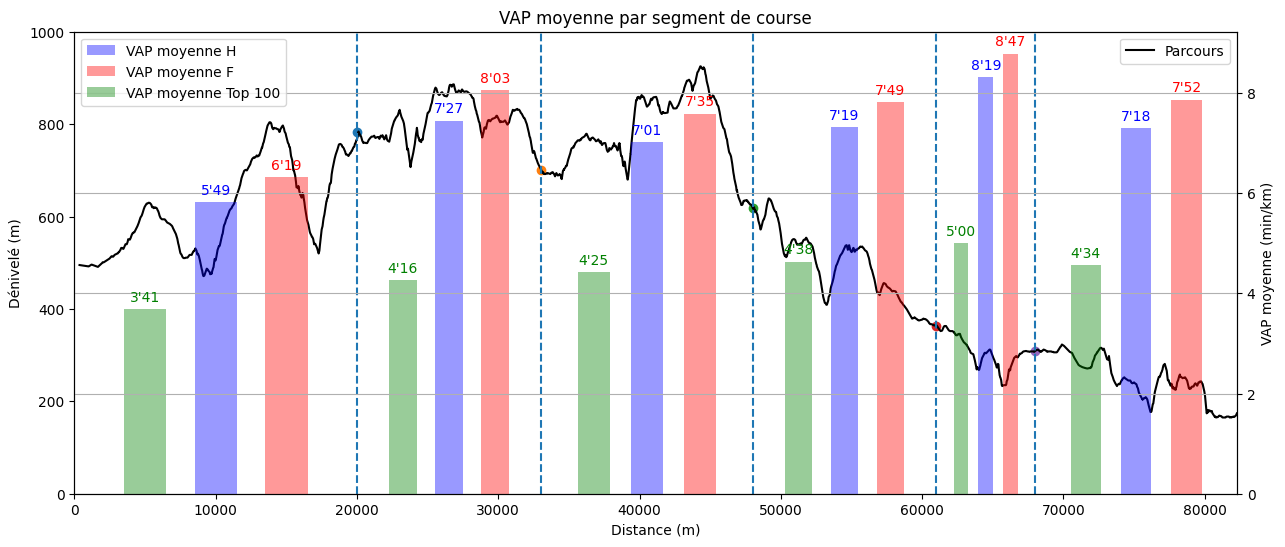

In [91]:
# plot l'évolution de la vap moyenne (courbe femme + courbe hommes + courbe top 100)

# calcul des VAP moyennes (en min/km) sur les segments
# Pour les H et F
mean_vap_str = {}
mean_vap_nbr = {}
for sexe in race_results_df["sexe"].unique():
    cat_vap_seconds = race_results_df[
        race_results_df["sexe"] == sexe
    ][
        [f"VAP_segment_{i}" for i in range(len(RAVITAILLEMENTS)+1)]
    ].mean().to_list()
    mean_vap_str[sexe] = []
    mean_vap_nbr[sexe] = []
    for vap_seconds in cat_vap_seconds:
        time = seconds_to_time(int(vap_seconds))
        if time[2] < 10:
            mean_vap_str[sexe].append(f"{time[1]}'0{time[2]}")
        else:
            mean_vap_str[sexe].append(f"{time[1]}'{time[2]}")
        mean_vap_nbr[sexe].append(time[1] + time[2] / 60)
# Pour le top 100
cat_vap_seconds = race_results_df[
        race_results_df["classement"] <= 100
    ][
        [f"VAP_segment_{i}" for i in range(len(RAVITAILLEMENTS)+1)]
    ].mean().to_list()
mean_vap_str["Top 100"] = []
mean_vap_nbr["Top 100"] = []
for vap_seconds in cat_vap_seconds:
    time = seconds_to_time(int(vap_seconds))
    if time[2] < 10:
        mean_vap_str["Top 100"].append(f"{time[1]}'0{time[2]}")
    else:
        mean_vap_str["Top 100"].append(f"{time[1]}'{time[2]}")
    mean_vap_nbr["Top 100"].append(time[1] + time[2] / 60)

# calcul du centre de chaque segment
segment_center = {}
segment_center["Top 100"] = [
    (RAVITAILLEMENTS[0]["distance"]) / 4
] + [
    (3 * RAVITAILLEMENTS[i]["distance"] + RAVITAILLEMENTS[i+1]["distance"]) / 4 for i in range(len(RAVITAILLEMENTS)-1)
] + [
    (3 * RAVITAILLEMENTS[-1]["distance"] + distances[-1]) / 4
]
segment_center["H"] = [
    (RAVITAILLEMENTS[0]["distance"]) / 2
] + [
    (RAVITAILLEMENTS[i]["distance"] + RAVITAILLEMENTS[i+1]["distance"]) / 2 for i in range(len(RAVITAILLEMENTS)-1)
] + [
    (RAVITAILLEMENTS[-1]["distance"] + distances[-1]) / 2
]
segment_center["F"] = [
    (3 * RAVITAILLEMENTS[0]["distance"]) / 4
] + [
    (RAVITAILLEMENTS[i]["distance"] + 3 * RAVITAILLEMENTS[i+1]["distance"]) / 4 for i in range(len(RAVITAILLEMENTS)-1)
] + [
    (RAVITAILLEMENTS[-1]["distance"] + 3 * distances[-1]) / 4
]

# calcul de la longueur de chaque segment
segment_length = np.array(
    [
        RAVITAILLEMENTS[0]["distance"]
    ] + [
        RAVITAILLEMENTS[i+1]["distance"] - RAVITAILLEMENTS[i]["distance"] for i in range(len(RAVITAILLEMENTS)-1)
    ] + [
        distances[-1] - RAVITAILLEMENTS[-1]["distance"]
    ]
)


if VERBOSE:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Graphique du parcours
    ax1.plot(distances, altitudes, color="black", label='Parcours')
    ax1.set_xlim([0, distances[-1]])
    ax1.set_xlabel('Distance (m)')
    ax1.set_ylim([0, 1000])
    ax1.set_ylabel('Dénivelé (m)', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # Ajout des ravitaillements
    for ravitaillement in RAVITAILLEMENTS:
        dist = ravitaillement["distance"]
        alt = altitudes[next((i for i, d in enumerate(distances) if d > dist), None)]
        ax1.scatter(x=[dist], y=alt)
        ax1.vlines(x=dist, ymin=0, ymax=1000, linestyles="--")


    # Définir le deuxième axe pour les VAP
    ax2 = ax1.twinx()
    ax2.set_ylabel('VAP moyenne (min/km)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    
    # Ajouter les VAP moyennes par segment
    bars = {}
    for cat in mean_vap_nbr.keys():
        bars = ax2.bar(
            segment_center[cat], 
            mean_vap_nbr[cat], 
            width=segment_length*0.15, 
            align='center', 
            color=colors[cat], 
            alpha=0.4,
            label=f"VAP moyenne {cat}"
        )
        for i, bar in enumerate(bars):
            y_position = bar.get_height()
            ax2.text(
                bar.get_x() + bar.get_width() / 2,
                y_position + 0.1,
                str(mean_vap_str[cat][i]),
                ha='center',
                va='bottom',
                color=colors[cat],
                fontsize=10
            )

    plt.title('VAP moyenne par segment de course')
    plt.grid(True)
    ax1.legend(loc="upper right")
    ax2.legend(loc="upper left")
    plt.show()

- Même si les hommes vont plus vite en moyenne, les femmes et les hommes ont le même comportement global:
    - Les athlètes partent vite (la VAP la plus basse est celle du premier segment)
    - Ils semblent en payer les frais sur le second segment avec un net ralentissement
    - Ils réaccélèrent légèrement sur le 3ème segment
    - Mais décèlèrent progressivement sur les segments 4 et 5
    - Enfin ils accélèrent sur le dernier segment

- Les athlètes du top 10, quand à eux, ralentissent continuellement tout au long de la course, sauf sur le dernier segment où ils ré-accélèrent

## 3.3. Création de la métrique de VAPe (VAP effort)

La VAPe (ou VAP effort) est définie comme la VAP de l'athlète **comme s'il courrait à cette vitesse 100% reposé (i.e. en début de course)**. 

Pour la calculer on multiplie la VAP réelle par un coefficient d'effort qui dépend du segment. L'objectif est de rendre les VAP moyennes des différents segments comparables entre elles.

`VAPe = VAP * c(segment)`

Comme nous n'avons que peu de données, nous allons utiliser une méthode simple: nous allons multiplier, pour chaque athlète, la VAP de chaque segment par le rapport entre la VAP moyenne de l'ensemble des coureurs sur le premier segment et sur le segment considéré. Ceci permet de ramener chaque VAP à son équivalent "premier segment". On aura donc:

`c(segment i) = VAPmoyenne(segment 1) / VAPmoyenne(segment i)`

Afin de préserver les caractéristiques de chaque catégorie d'athlètes, nous appliquerons ce schéma par catégorie (`H`, `F` et `Top 100`)

On pourra alors voir si un athlète est allé plus ou moins vite que la moyenne sur chaque segment, mais surtout s'il va de plus en plus vite ou de moins en moins vite que la moyenne, ce qui nous indiquera son schéma de course.

In [92]:
# Définition de c

# H et F
coefficients = {}
for sexe in ["H", "F"]:
    mean_vap = race_results_df[
            race_results_df["sexe"] == sexe
        ][
            [f"VAP_segment_{i}" for i in range(len(RAVITAILLEMENTS)+1)]
        ].mean().to_list()
    coefficients[sexe] = [mean_vap[0] / vap for vap in mean_vap]

# Top 100
mean_vap = race_results_df[
    race_results_df["classement"] <= 100
][
    [f"VAP_segment_{i}" for i in range(len(RAVITAILLEMENTS)+1)]
].mean().to_list()
coefficients["Top 100"] = [mean_vap[0] / vap for vap in mean_vap]

In [93]:
# VAPe (si un athlète est dans le top 100 alors on lui applique par défaut le coefficient de cette catégorie, qu'il soit H ou F)


def cat_vap_e(row):
    if row["classement"] <= 100:
        return "Top 100"
    else:
        return row["sexe"]


def vap_e(row, coefficients, segment):
    if row["classement"] <= 100:
        return row[f"VAP_segment_{segment}"] * coefficients["Top 100"][segment]
    else:
        return row[f"VAP_segment_{segment}"] * coefficients[row["cat_VAPe"]][segment]

race_results_df["cat_VAPe"] = race_results_df.apply(
        lambda row: cat_vap_e(row), axis=1
    )
for i in range(len(RAVITAILLEMENTS)+1):
    race_results_df[f"VAPe_segment_{i}"] = race_results_df.apply(
        lambda row: vap_e(row, coefficients, i), axis=1
    )

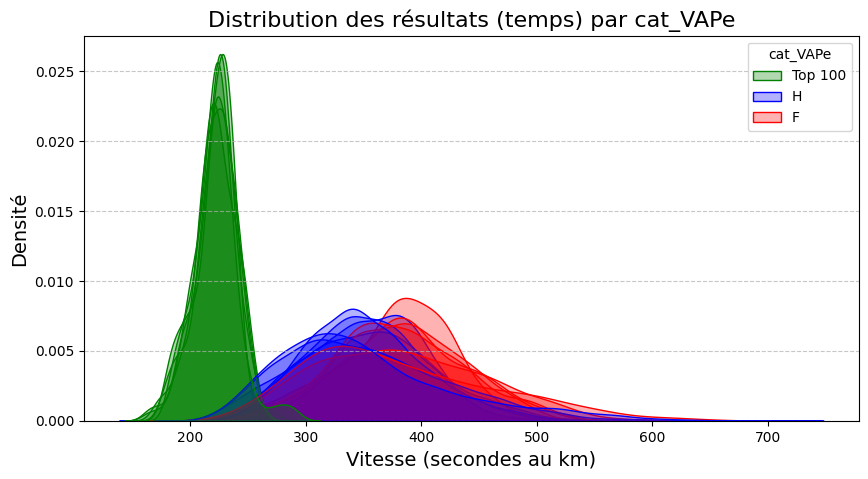

In [94]:
# Plot VAPe de toutes les catégories (filtrage par segment possible)

segment = None

if VERBOSE:
    plt.figure(figsize=(10, 5))
    if segment is None:
        for i in range(len(RAVITAILLEMENTS) + 1):  
            sns.kdeplot(
                data=race_results_df, 
                x=f"VAPe_segment_{i}", 
                hue="cat_VAPe", 
                fill=True, 
                common_norm=False, 
                alpha=0.3, 
                legend=True, 
                palette=palette_dict
            )
    else:
        sns.kdeplot(
            data=race_results_df, 
            x=f"VAPe_segment_{segment}", 
            hue="cat_VAPe", 
            fill=True, 
            common_norm=False, 
            alpha=0.3, 
            legend=True, 
            palette=palette_dict
        )

    plt.title("Distribution des résultats (temps) par cat_VAPe", fontsize=16)
    plt.xlabel("Vitesse (secondes au km)", fontsize=14)
    plt.ylabel("Densité", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

## 3.4. Définition de la dynamique de course

Maintenant que nous avons une vitesse ajustée à la pente et à l'effort passé, nous allons pouvoir observer si un athlète a eu une course plutôt:
- De type accélération progressive
- De type décélération progressive
- De type constante

C'est ce que nous appelerons le schéma de course.

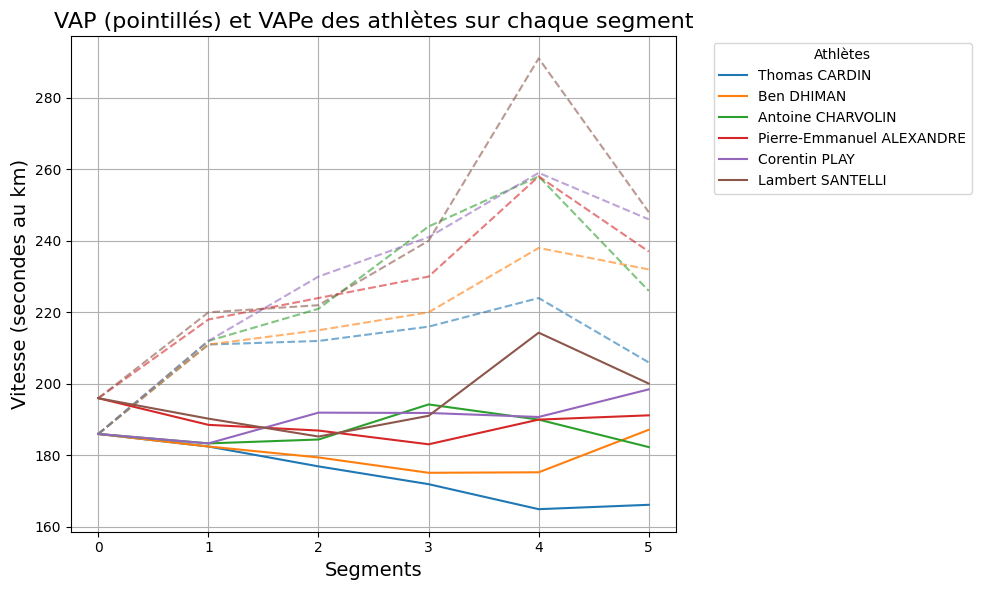

In [111]:
# Commençons par comparer les dynamiques de certains athlètes du top 10
race_results_top_5_df = race_results_df[race_results_df["classement"] <= 10]
plot_df = race_results_top_5_df[
    ["classement", "nom", "sexe"]
    + [f"VAP_segment_{i}" for i in range(len(RAVITAILLEMENTS)+1)]
    + [f"VAPe_segment_{i}" for i in range(len(RAVITAILLEMENTS)+1)]
]

athlete_colors = {row.nom: plt.cm.tab10(i) for i, row in enumerate(race_results_top_5_df.itertuples())}

if VERBOSE:
    plt.figure(figsize=(10, 6))

    for _, row in plot_df.iterrows():
        plt.plot(
            range(6),
            row[[f"VAP_segment_{i}" for i in range(len(RAVITAILLEMENTS)+1)]],
            color=athlete_colors[row['nom']],
            linestyle="--",
            alpha=0.6
        )
        plt.plot(
            range(6),
            row[[f"VAPe_segment_{i}" for i in range(len(RAVITAILLEMENTS)+1)]],
            color=athlete_colors[row['nom']],
            label=row['nom'],
        )

    plt.title("VAP (pointillés) et VAPe des athlètes sur chaque segment", fontsize=16)
    plt.xlabel("Segments", fontsize=14)
    plt.ylabel("Vitesse (secondes au km)", fontsize=14)
    plt.legend(title="Athlètes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

On observe différentes dynamiques de course:
- Des athlètes comme Thomas CARDIN et Ben DHIMAN (respectivements 1 et 2 de la course) on progressivement augmenté leur VAPe au fur et à mesure de la course, même s'ils ont ralenti à la fin. On comprend d'ailleurs simplement avec ces courbes comment s'est jouée la victoire: Ces deux coureurs se sont rapidement démarqués du groupe, et c'est finalement celui qui n'a pas su soutenir son effort aussi longtemps qui a laissé la victoire à l'autre.
- Des athlètes comme Pierre-Emmanuel ALEXANDRE et Antoine Charvolin on eu une course relativement constante. En effet, leur VAP diminue de manière linéaire ce qui se voit sur leur VAPe, qui reste relativement constante.
- Enfin, on voit que Lambert SANTELLI et Corentin PLAY, qui semblait courir proche des athlètes de la catégorie précédente, ont eu un gros coup de moins bien sur le segment 4, perdant beaucoup de temps. Ce segment étant principalement en descente, on peut se demander s'ils ont subit une blessure ou si ce ralentissement est simplement caractéristique d'un manque de force à ce moment.

In [153]:
# Nous aimerions classer l'ensemble des athlètes dans l'une de ces 3 catégories
# Pour cela nous allons regarder si leurs courbes de VAPe sont globalement croissantes, stables ou décroissantes

def schema_de_course(row):
    y = row[[f"VAPe_segment_{i}" for i in range(len(RAVITAILLEMENTS)+1)]].astype(float)
    x = np.array(segment_center[row["cat_VAPe"]]) / 1000 # distances en km
    slope, _ = np.polyfit(x, y, 1) # slope en secondes gagnées/perdues par km
    if slope > 0.05:
        return "ralentissement"
    elif slope < -0.05:
        return "acceleration"
    else:
        return "constant"
    

race_results_df["schema_de_course"] = race_results_df.apply(
        lambda row: schema_de_course(row), axis=1
    )

In [154]:
if VERBOSE:
    display(race_results_df[race_results_df["classement"] <= 10][["nom", "schema_de_course"]])

,nom,schema_de_course
0,Thomas CARDIN,acceleration
1,Ben DHIMAN,acceleration
2,Antoine CHARVOLIN,constant
3,Pierre-Emmanuel ALEXANDRE,acceleration
4,Corentin PLAY,ralentissement
5,Lambert SANTELLI,ralentissement


Les résultats sont cohérents avec notre analyse visuelle, sauf pour Pierre-Emmanuel ALEXANDRE qui semble avoir accéléré d'avantage que ce que le visuel laisait paraître.

/var/folders/0x/z3rw_6ls2hl969v2c8425rf40000gn/T/ipykernel_5820/4103443441.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for _, row in race_results_df[:100][race_results_df["schema_de_course"] == schema_de_course].iterrows():


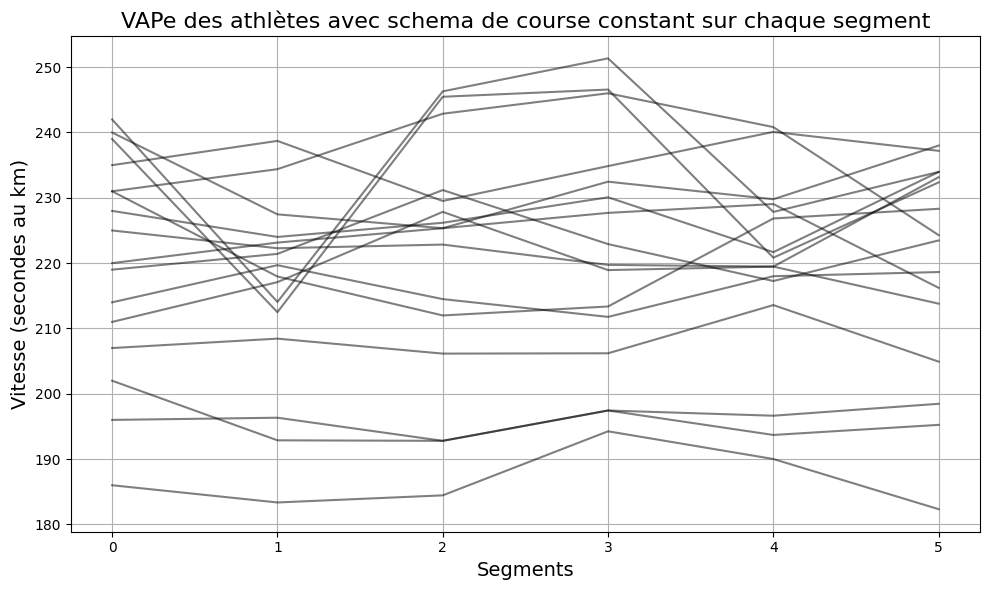

In [165]:
# Ensemble des schema de course du top 100

schema_de_course = "constant"

if VERBOSE:
    athlete_colors = {
        "acceleration": "green",
        "constant": "black",
        "ralentissement": "red",
    }
    
    plt.figure(figsize=(10, 6))

    for _, row in race_results_df[:100][race_results_df["schema_de_course"] == schema_de_course].iterrows():
        plt.plot(
            range(6),
            row[[f"VAPe_segment_{i}" for i in range(len(RAVITAILLEMENTS)+1)]],
            color=athlete_colors[row["schema_de_course"]],
            alpha=0.5,
        )

    plt.title(f"VAPe des athlètes avec schema de course {schema_de_course} sur chaque segment", fontsize=16)
    plt.xlabel("Segments", fontsize=14)
    plt.ylabel("Vitesse (secondes au km)", fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

On voit qu'une des limite de cette métrique de `schéma de course` est qu'elle classe comme `constant` les coureurs qui en moyenne le sont, mais avec de grandes variance tout au long de la course.

## 3.5. Réponse à notre problématique

Nous touchons au but.

Pour répondre à notre question initiale, nous allons regarder si, à index ITRA équivalent, l'un des schéma de course mène à un meilleure résultat.

Comme jusqu'à présent, nous allons regarder 3 cas: les hommes, les femmes et le top 100.

In [184]:
palette_dict = dict(zip(
    ["acceleration", "constant", "ralentissement"], 
    sns.color_palette(["green", "grey", "red"])
))

temps
cat_VAPe schema_de_course              
F        acceleration      44160.297872
         constant          43143.787879
         ralentissement    50138.350181
H        acceleration      41655.998549
         constant          41317.201493
         ralentissement    45683.059701
Top 100  acceleration      26798.000000
         constant          26094.500000
         ralentissement    26538.032258

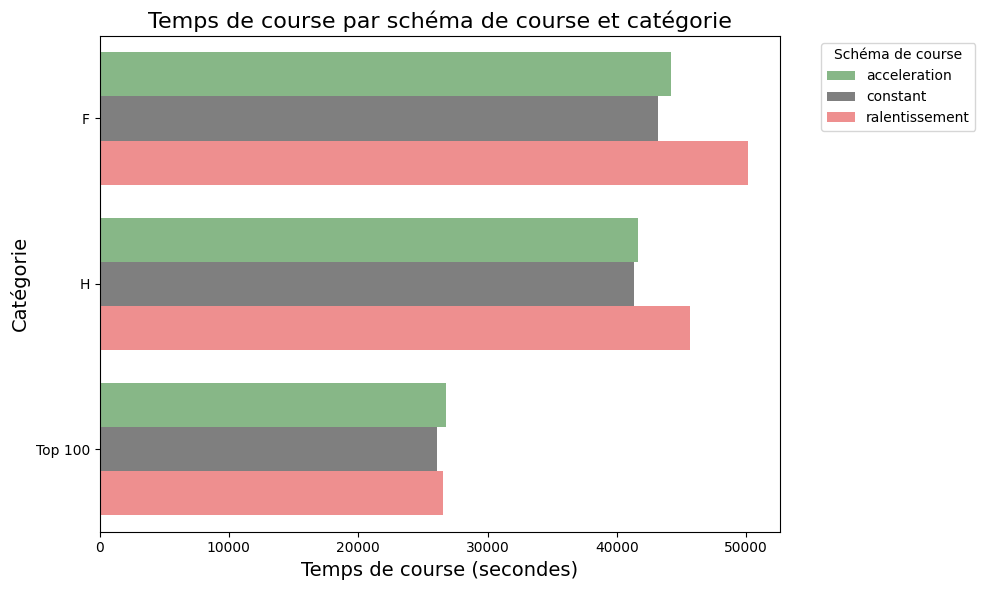

In [186]:
# Commençons par observer l'impact général du schéma de course sur le résultat

if VERBOSE:
    temps_df = race_results_df[["schema_de_course", "cat_VAPe", "temps"]].groupby(
        ["cat_VAPe", "schema_de_course"]
    ).mean()
    temps_df["temps(h,m,s)"] = temps_df["temps"].apply(
        lambda x: f"{int(seconds_to_time(x)[0])}h {int(seconds_to_time(x)[1])}s {int(seconds_to_time(x)[2])}s"
    )
    display(temps_df[["temps"]])

    palette_dict = athlete_colors
    plt.figure(figsize=(10, 6))
    sns.barplot(x="temps", y="cat_VAPe", hue="schema_de_course", data=temps_df, orient="h", dodge=True, palette=palette_dict, alpha=0.5)
    plt.title("Temps de course par schéma de course et catégorie", fontsize=16)
    plt.xlabel("Temps de course (secondes)", fontsize=14)
    plt.ylabel("Catégorie", fontsize=14)
    plt.legend(title="Schéma de course", loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

Au global, il en ressort que:
- Le schéma de course constant est le plus rapide pour tous
- Pour les femmes comme pour les hommes, ceux qui partent trop vite finissent derrière
- **Pour les athlètes du top 100 néanmoins, c'est l'inverse! Ceux qui partent trop lentement ne parviennent en moyenne pas à rattraper leur retard et finissent derrière ceux qui sont partis rapidement.**

temps
index      schema_de_course              
300 - 400  acceleration      51056.464789
           constant          51497.200000
           ralentissement    53866.722348
400 - 500  acceleration      45801.343619
           constant          45605.968254
           ralentissement    49856.464632
500 - 600  acceleration      38994.302752
           constant          39155.024691
           ralentissement    42598.507968
600 - 700  acceleration      34424.023810
           constant          32878.642857
           ralentissement    34736.576037
700 - 800  acceleration      28575.131579
           constant          28964.500000
           ralentissement    29852.404255
800 - 900  acceleration      24156.000000
           constant          24598.833333
           ralentissement    24525.714286
900 - 1000 acceleration      21473.000000

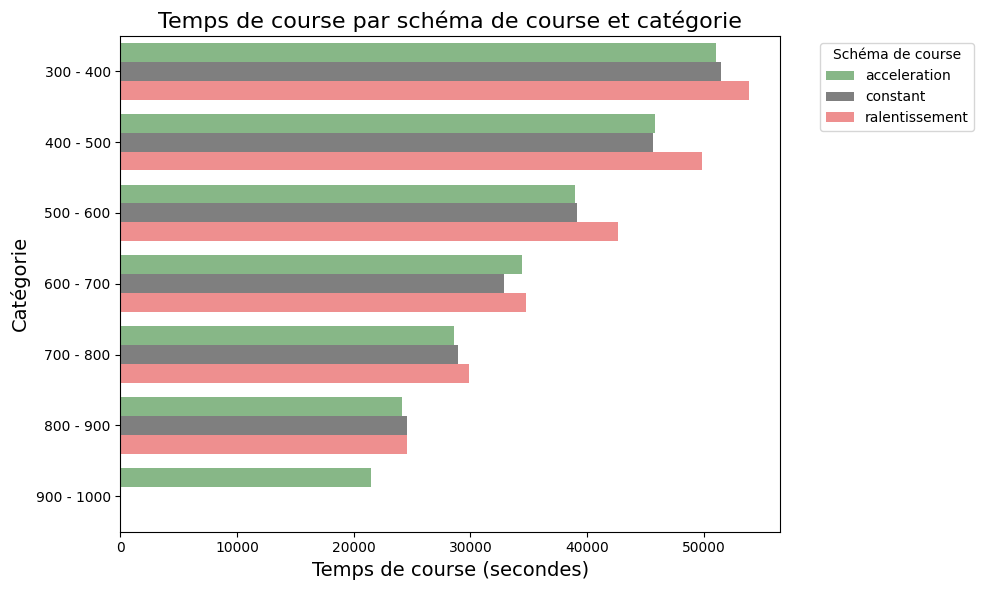

In [197]:
# Observons maintenant s'il y a des spécificités par valeur d'index

if VERBOSE:
    temps_df = race_results_df[["index", "schema_de_course", "temps"]].dropna()
    temps_df['index'] = temps_df['index'].apply(
        lambda x: f"{int((x // 100) * 100)} - {int((x // 100 + 1)) * 100}"
    )
    temps_df = temps_df.groupby(["index", "schema_de_course"]).mean()
    temps_df["temps(h,m,s)"] = temps_df["temps"].apply(
        lambda x: f"{int(seconds_to_time(x)[0])}h {int(seconds_to_time(x)[1])}s {int(seconds_to_time(x)[2])}s"
    )
    display(temps_df[["temps"]])

    palette_dict = athlete_colors
    plt.figure(figsize=(10, 6))
    sns.barplot(x="temps", y="index", hue="schema_de_course", data=temps_df, orient="h", dodge=True, palette=palette_dict, alpha=0.5)
    plt.title("Temps de course par schéma de course et catégorie", fontsize=16)
    plt.xlabel("Temps de course (secondes)", fontsize=14)
    plt.ylabel("Catégorie", fontsize=14)
    plt.legend(title="Schéma de course", loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

# END OF NOTEBOOK